# 06: Linear models

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mylib as my

# Linear regression
Here we have $n$ examples each with an $m$ features. For a single example $(\mathbf{x}, y)$ The linear regression model is written as:
$$h(\mathbf{x}) = w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_m x_m$$
where $w_0, w_1, \cdots, w_m$ are the weight parameters we are trying to learn. 

In this case we have a regression hyperplane instead of a regression line. 

We can express this model for this single example using the matrix notation like this:

$$h(\mathbf{x}) = \mathbf{w}^T \mathbf{x}$$

For the entire training dataset, we have:
$$h(\mathbf{X}) = \mathbf{X} \mathbf{w}$$


### Using the normal equation
Using the $L_2$ loss function which is defined as:

$$L_2 = \frac{1}{2} \sum_{i=1}^n (y^{(i)} - h(\mathbf{x}^{(i)}))^2 = \frac{1}{2} \sum_{i=1}^n (y^{(i)} - \mathbf{w}^T \mathbf{x}^{(i)})^2$$
     
or in matrix notation as:
    $$L_2 = \frac{1}{2} (\mathbf{y} - h(\mathbf{X}))^T(\mathbf{y} - h(\mathbf{X})) = \frac{1}{2} (\mathbf{y} - \mathbf{X} \mathbf{w})^T(\mathbf{y} - \mathbf{X} \mathbf{w})$$

We can use the following equation to find the weight parameters $\mathbf{w}$ that minimize the loss equation $L_2$:

$$ \mathbf{w}  = (\mathbf{X}^T \mathbf{X} )^{-1} \mathbf{X}^T \mathbf{y}$$


In [2]:
class LinearRegressor:
    def __init__(self, dataset):
        self.ds = dataset
        
    def fit(self):
        X = np.concatenate((np.ones((self.ds.N, 1)), self.ds.inputs), axis=1)
        self.w = np.dot(np.linalg.pinv(X), y)

    def predict(self, unseen):
        if unseen.ndim == 1:
            x = np.insert(unseen, 0, 1) # adding the bias weight
            return np.dot(x, self.w)
        else:
            return np.array([self.predict(ex) for ex in unseen])

Let's test it. First we create a sample dataset

In [3]:
x = np.arange(0, 15, .1)
y = 2 * x + 2 + np.random.normal(loc=2, scale=5, size=len(x))

df = pd.DataFrame({'x': x, 'y': y})
data = my.DataSet(df, y=True)

Let's plot this data:

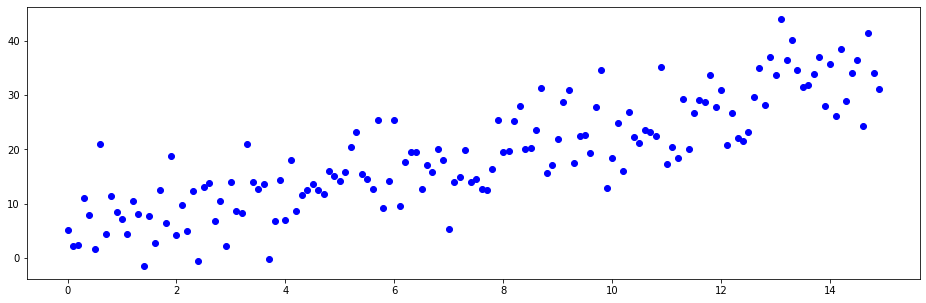

In [4]:
# plottong
fig = plt.figure(figsize=(16,5))
plt.scatter(x, y, color='b', marker='o')

Let's fit this data using the above linear regression

In [5]:
lg = LinearRegressor(data)
lg.fit()

print (lg.w)

[4.41945946 1.96901541]


And here is the regression line

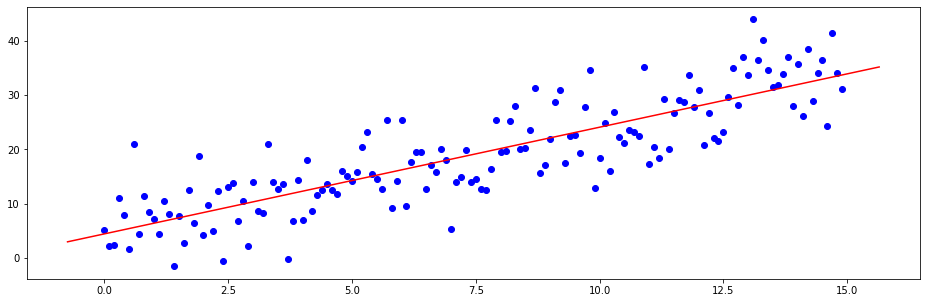

In [6]:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x, y, color='b', marker='o')

x1, x2 = ax.get_xlim()

input = np.array([[x1], [x2]])
output = lg.predict(input)

ax.plot((x1, x2), output.ravel(), 'r-')

### Using gradient descent
Given a loss function $L(\mathbf{w})$, we can try to find $\mathbf{w}$ that minimizes the loss function using gradient descent:

$$\mathbf{w} = \mathbf{w} - \eta \nabla L(\mathbf{w})$$

where $\eta$ is the learning rate and $\nabla L(\mathbf{w})$ is the gradient (a vector of partial derivatives one for each $w_i$).

For a single weight $w_i$ given a single example $(\mathbf{x}, y)$.

$$w_i = w_i - \eta \frac{\delta L(\mathbf{w})}{\delta w_i}$$
If $L$ is $L_2$ then:
$$w_i = w_i - \eta \frac{\delta\ \ \frac{1}{2}(y - \mathbf{w}^T \mathbf{x})^2}{\delta w_i}$$

which gives us the update rule:
$$w_i = w_i + \eta (y - \mathbf{w}^T \mathbf{x}) x_i$$

In [7]:
class GDLinearRegressor:
    def __init__(self, dataset, eta=.0001, epochs=10, random_state=17):
        self.ds = dataset
        self.eta = eta
        self.epochs = epochs
        self.random_state = random_state
    
    def fit(self):
        X = np.concatenate([np.ones(self.ds.N).reshape(self.ds.N, 1), self.ds.inputs], axis=1)
        n = X.shape[0]
        m = X.shape[1]
        rgen = np.random.RandomState(self.random_state)
        self.w = rgen.normal(loc=0.0, scale=0.01, size=m).reshape(m, 1)
        
        self.loss_hist = []
        for e in range(self.epochs): 
            predicted = np.dot(X, self.w)
            error = self.ds.target - predicted
            loss = (1/n) * np.dot(error.T, error) # dividing by n to scale the cost down
            self.loss_hist.append(loss[0,0] / n) 
            self.w = self.w + (self.eta) * np.dot(X.T, error)
    
    def predict(self, unseen):
        if unseen.ndim == 1:
            x = np.insert(unseen, 0, 1) # adding the bias weight
            return np.dot(x, self.w)
        else:
            return np.array([self.predict(ex) for ex in unseen])

Let's test is using the same dataset as above

In [8]:
gd = GDLinearRegressor(data)
gd.fit()

print(gd.w)

[[0.39907489]
 [2.37376113]]


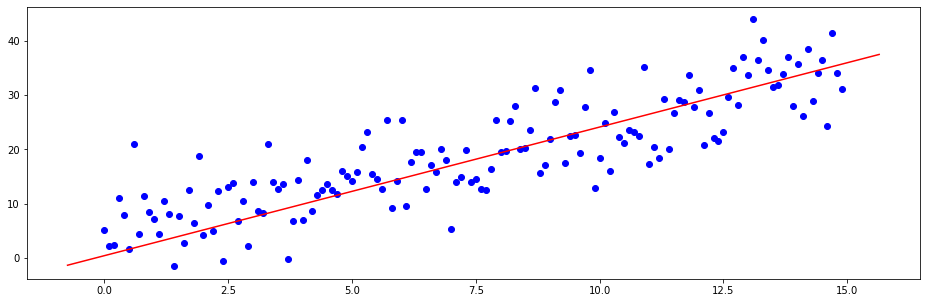

In [9]:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(x, y, color='b', marker='o')

x1, x2 = ax.get_xlim()

input = np.array([[x1], [x2]])
output = gd.predict(input)

ax.plot((x1, x2), output.ravel(), 'r-')

### The learning curve

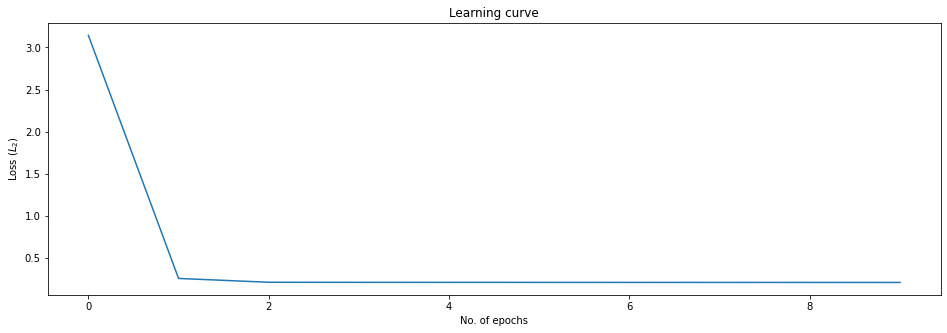

In [10]:
gd = GDLinearRegressor(data)
gd.fit()

fig = plt.figure(figsize=(16, 5))

plt.title('Learning curve')
plt.xlabel('No. of epochs')
plt.ylabel('Loss ($L_2$)')
plt.plot(gd.loss_hist)

### Changing epochs and $\eta$
And we can even plot the regression lines after different numbers of epochs (an epoch is a one pass over the entire training dataset). 

When the learning rate $\eta$ is just about right, the convergence happens quickly.

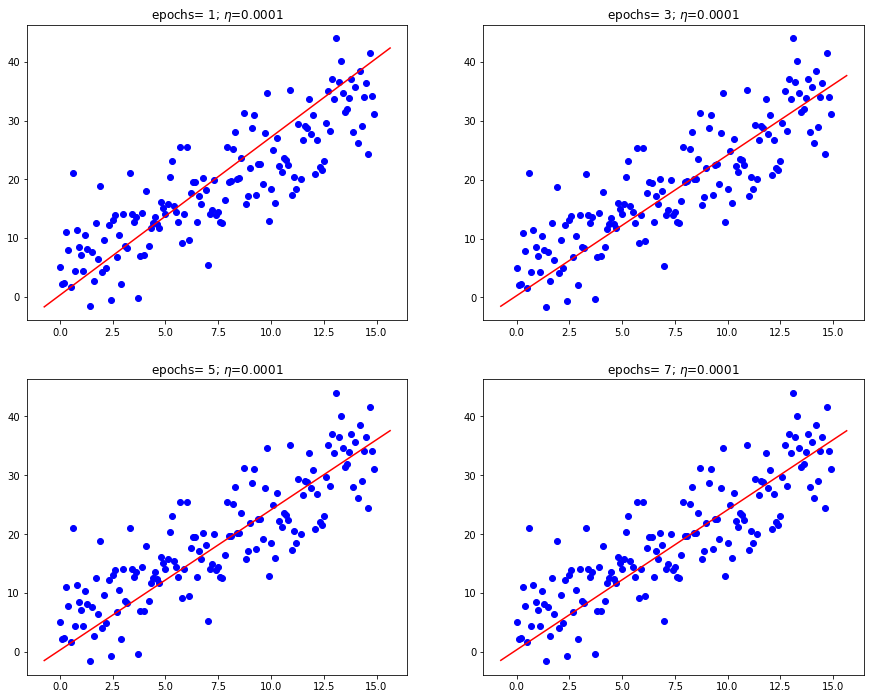

In [11]:
fig = plt.figure(figsize=(15,25))
n = 4
eta = 0.0001
for i in range(n):
    gd = GDLinearRegressor(data, eta=eta, epochs=2 * i + 1)
    gd.fit()
    ax = fig.add_subplot(n, 2, i + 1)
    ax.scatter(x, y, color='b', marker='o')

    x1, x2 = ax.get_xlim()

    input = np.array([[x1], [x2]])

    output = gd.predict(input)

    ax.plot((x1, x2), output.ravel(), 'r-')
    plt.title(f'epochs= {2 * i + 1}; $\eta$=0.0001')

When the learning rate $\eta$ is small, the convergence takes more epochs.

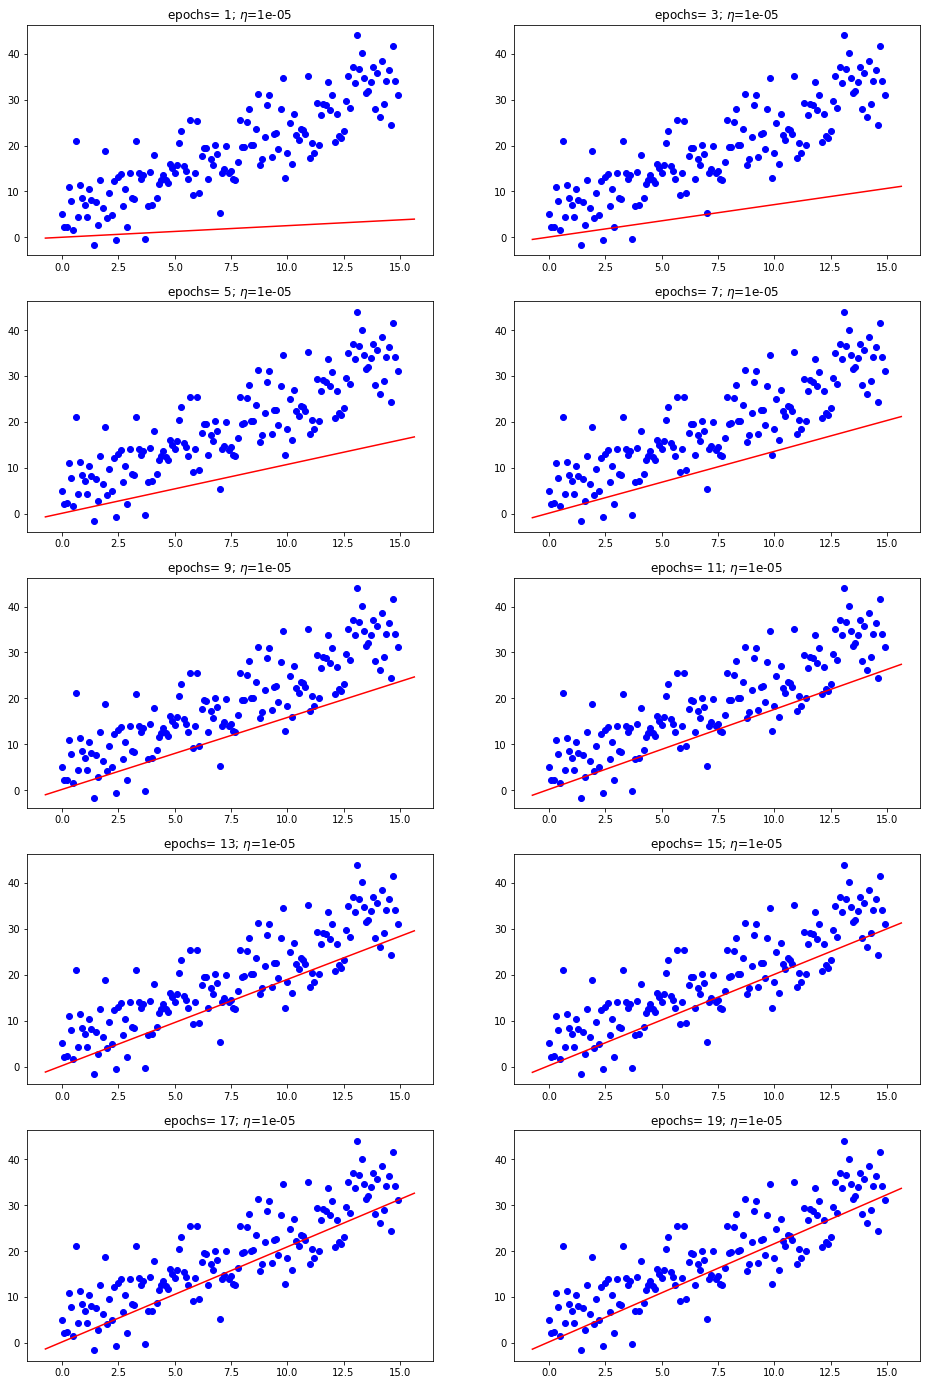

In [12]:
fig = plt.figure(figsize=(16,50))
n = 10
eta = 0.00001
for i in range(n):
    gd = GDLinearRegressor(data, eta=eta, epochs=2 * i + 1)
    gd.fit()
    ax = fig.add_subplot(n, 2, i + 1)
    ax.scatter(x, y, color='b', marker='o')

    x1, x2 = ax.get_xlim()

    input = np.array([[x1], [x2]])

    output = gd.predict(input)

    ax.plot((x1, x2), output.ravel(), 'r-')
    plt.title(f'epochs= {2 * i + 1}; $\eta$={eta}')

And here is it when the learning rate $\eta$ is too large.

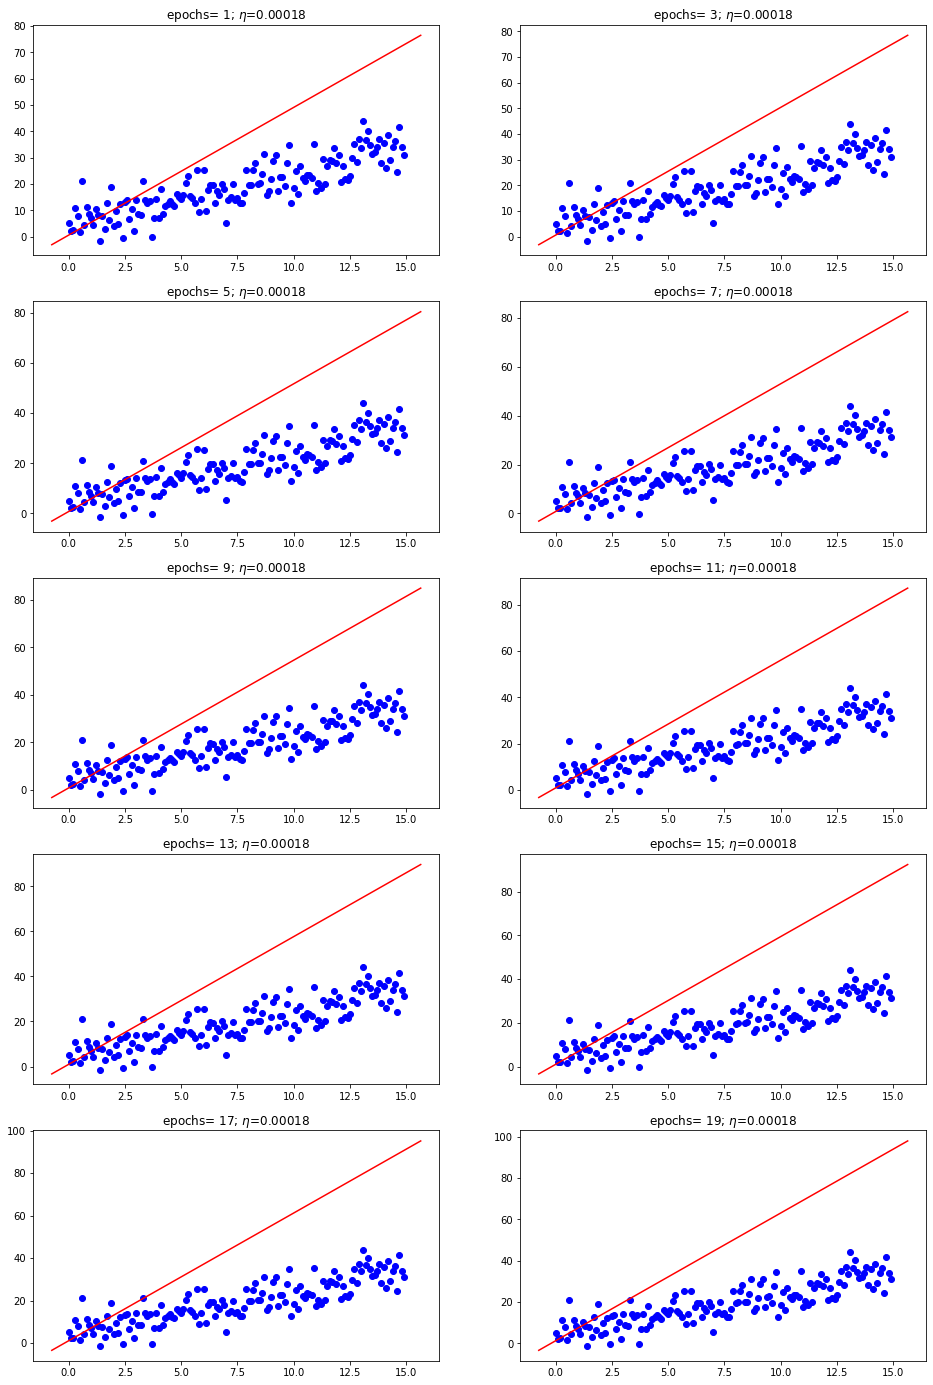

In [13]:
fig = plt.figure(figsize=(16,50))
n = 10
eta = 0.00018
for i in range(n):
    gd = GDLinearRegressor(data, eta=eta, epochs=2 * i + 1)
    gd.fit()
    ax = fig.add_subplot(n, 2, i + 1)
    ax.scatter(x, y, color='b', marker='o')

    x1, x2 = ax.get_xlim()

    input = np.array([[x1], [x2]])

    output = gd.predict(input)

    ax.plot((x1, x2), output.ravel(), 'r-')
    plt.title(f'epochs= {2 * i + 1}; $\eta$={eta}')

## CHALLENGE A
Take the above plots where $\eta$ is too big and draw next to each plot its corresponding learning curve.

In [14]:
# TODO

## Logistic regression

In [15]:
class LogisticRegressor:
    def __init__(self, dataset, eta=.0001, epochs=10, random_state=17):
        self.ds = dataset
        self.eta = eta
        self.epochs = epochs
        self.random_state = random_state
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self):
        X = np.concatenate([np.ones(self.ds.N).reshape(self.ds.N, 1), self.ds.inputs], axis=1)
        n = X.shape[0]
        m = X.shape[1]
        rgen = np.random.RandomState(self.random_state)
        self.w = rgen.normal(loc=0.0, scale=0.01, size=m).reshape(m, 1)
        for i in range(self.epochs): 
            z = np.dot(X, self.w)
            h = self.sigmoid(z)
            self.w = self.w + self.eta * np.dot(X.T, (self.ds.target - h))
            
    def predict(self, unseen, threshold=.5):
        """ Returns probabilites unless a valid threshold is given"""
        if unseen.ndim == 1:
            x = np.insert(unseen, 0, 1) # adding the bias weight
            
            if threshold != None and 0.0 < threshold < 1.0:
                return 1 if self.sigmoid(np.dot(x, self.w)) >= threshold else 0
            else:
                return self.sigmoid(np.dot(x, self.w))
        else:
            return np.array([self.predict(ex, threshold) for ex in unseen])

Let's generate some binary classification data

In [16]:
n = 150
data = np.array([[3, 14],[10, 9]])
d0 = np.concatenate((data[0,0] + np.random.normal(loc=1, scale=2.8, size=(n, 1)), 
                data[0, 1] + np.random.normal(loc=1, scale=1.2, size=(n, 1)), np.zeros(n).reshape(n, 1)), axis= 1)

d1 = np.concatenate((data[1,0] + np.random.normal(loc=.5, scale=2.5, size=(n, 1)), 
                data[1, 1] + np.random.normal(loc=.5, scale=1, size=(n, 1)), np.ones(n).reshape(n, 1)), axis= 1)


d = np.concatenate((d0, d1), axis=0)
data = my.DataSet(pd.DataFrame(d, columns=['x1', 'x2', 'y']), y=True)

Here is how the generated data looks like:

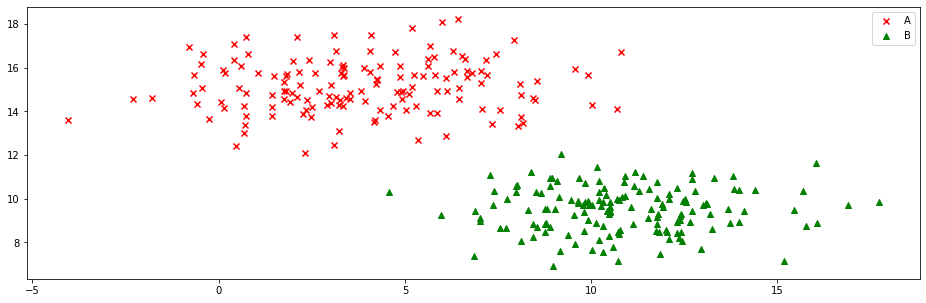

In [17]:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1, 1, 1)
a_ = data.examples[data.examples['y'] == 0].iloc[:, :-1].values
ax.scatter(a_[:, 0], a_[:, 1], color='red', marker='x', label='A')

b_ = data.examples[data.examples['y'] == 1].iloc[:, :-1].values
ax.scatter(b_[:, 0], b_[:, 1], color='green', marker='^', label='B')

ax.legend(loc='best')

We now split this data into training and test sets

In [18]:
train, test = data.train_test_split(test_portion=0.33, shuffle=True)

We now can train our logistic regressor

In [19]:
logr = LogisticRegressor(train)
logr.fit()
print(logr.w)

[[ 0.00644061]
 [ 0.23285512]
 [-0.14836857]]


which gives us the following confusion matrix and accuracy

In [20]:
cm = my.confusion_matrix(train.target, logr.predict(train.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Training accuracy: ', accuracy)

[[99  3]
 [ 1 98]]
Training accuracy:  0.9800995024875622


Here is the corresponding decision regions:

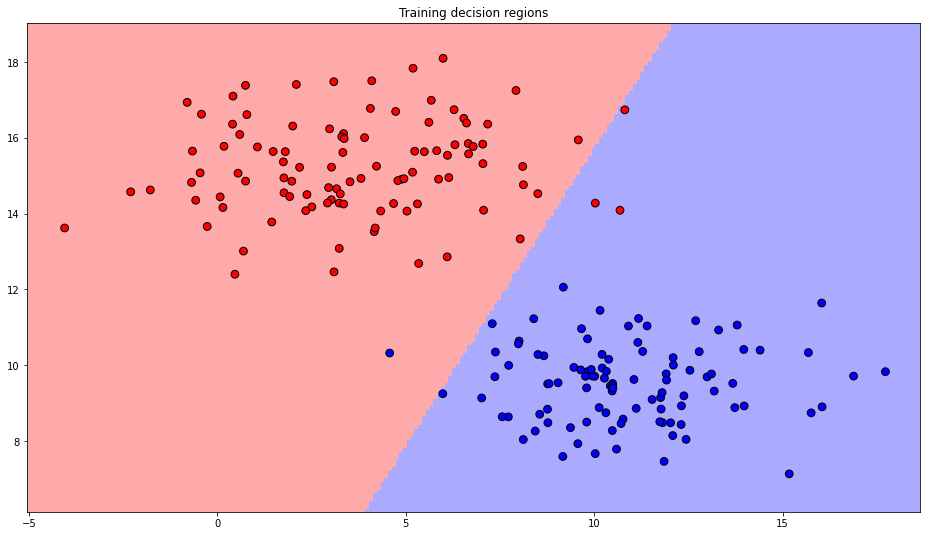

In [21]:
my.plot_decision_regions(train.inputs, train.target, logr, resolution=0.1, title="Training decision regions")

Let's now test our trained logistic model and plot the test decision regions:

[[48  0]
 [ 0 51]]
Test accuracy:  1.0


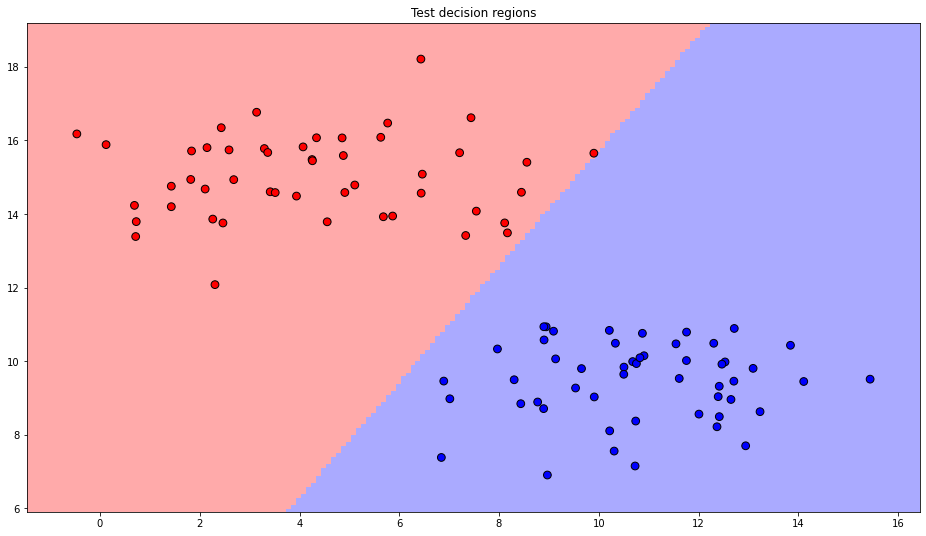

In [22]:
cm = my.confusion_matrix(test.target, logr.predict(test.inputs, threshold=.5))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Test accuracy: ', accuracy)

my.plot_decision_regions(test.inputs, test.target, logr, resolution=0.1, title="Test decision regions")

## CHALLENGE B
Refactor the `LogisticRegressor` class above to as to make it possible to draw the learning curve. Test your revised class by drawing the learning curve of the above training set.